# "Next Generation Reservoir Computing"

Daniel J. Gauthier, Erik Bollt, Aaron Grifﬁth & Wendson A. S. Barbosa


*Nature Communications*, vol. 12, no. 1, p. 5564, Sep. 2021, doi: 10.1038/s41467-021-25801-2.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import reservoirpy as rpy

from matplotlib import cm, colors
from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

rpy.verbosity(0)

0

## 1. NVAR for Lorenz strange attractor forecating

Lorenz attractor is defined by three coupled differential equations:

$$
\begin{split}
\dot{x} &= 10(y-x)\\
\dot{y} &= x(28-z)\\
\dot{z} &= xy - \frac{8z}{3}
\end{split}
$$

In [2]:
# time step duration (in time unit)
dt = 0.025
# training time (in time unit)
train_time  = 10.
# testing time (idem)
test_time   = 120.
# warmup time (idem): should always be > k * s
warm_time   = 5.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [3]:
x0 = [17.67715816276679, 12.931379185960404, 43.91404334248268]
n_timesteps = train_steps + test_steps + warm_steps

X = lorenz(n_timesteps, x0=x0, h=dt, method="RK23")

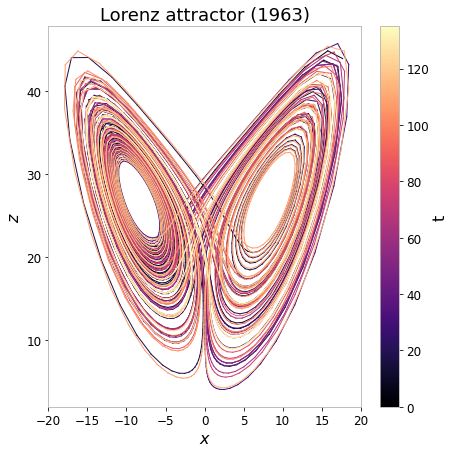

In [4]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111)
ax.set_title("Lorenz attractor (1963)")
ax.set_xlabel("$x$")
ax.set_ylabel("$z$")
ax.set_xlim(-20, 20)
ax.grid(False)

for i in range(n_timesteps-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 2], color=plt.cm.magma(255*i//n_timesteps), lw=1.0)
    
plt.colorbar(
    cm.ScalarMappable(colors.Normalize(vmin=0, vmax=train_time+test_time+warm_time), cmap="magma"), 
    ax=ax, 
    label="t")

plt.show()

The NVAR is connected to a readout layer with offline learning using regularized linear regression. The regularization parameter is set to $2.5\times10^{-6}$.

The model is first trained to infer the value of $\mathbf{X}[t+1]$ knowing the value of $\mathbf{X}[t]$. This training step enable the model to learn an internal representation of the local dynamics of the attractor.

In [5]:
nvar = NVAR(delay=2, order=2, strides=1)
readout = Ridge(3, ridge=2.5e-6)

model = nvar >> readout

We warmup the NVAR. The warmup time can be as short as only $k \times s$ steps. The NVAR has relevant features as soon as all the delayed signals are non zeros, i.e. as soon as at leas $k \times s$ steps has been stores in the linear vector. Then, train the model to perform one-step-ahead prediction.

In [6]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

model = model.fit(Xi, dXi, warmup=warm_steps)

In [7]:
lin = ["$x_t$", "$y_t$", "$z_t$", "$x_{t-1}$", "$y_{t-1}$", "$z_{t-1}$"]

nonlin = []
for idx in nvar._monomial_idx:
    idx = idx.astype(int)
    if idx[0] == idx[1]:
        c = lin[idx[0]][:-1] + "^2$"
    else:
        c = " ".join((lin[idx[0]][:-1], lin[idx[1]][1:]))

    nonlin.append(c)

coefs = ["$c$"] + lin + nonlin

In the plot below are displayed the linear coefficients learned by the model.

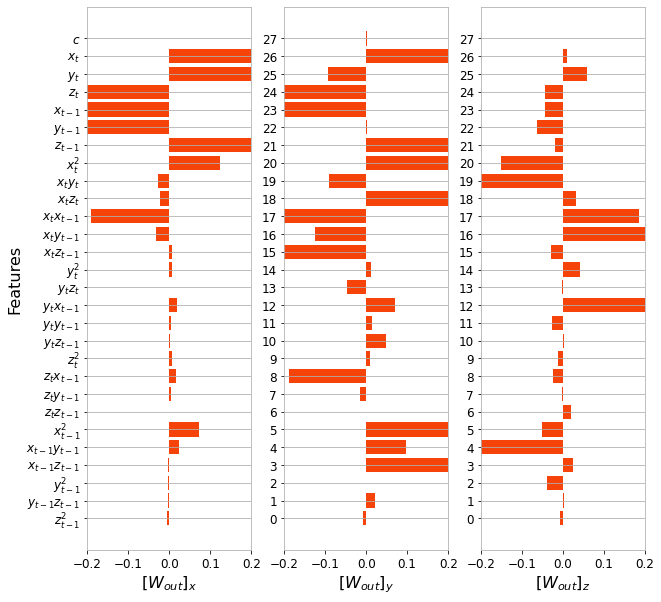

In [8]:
fig = plt.figure(figsize=(10, 10))

Wout = np.r_[readout.bias, readout.Wout]
x_Wout, y_Wout, z_Wout = Wout[:, 0], Wout[:, 1], Wout[:, 2]

ax = fig.add_subplot(131)
ax.set_xlim(-0.2, 0.2)
ax.grid(axis="y")
ax.set_xlabel("$[W_{out}]_x$")
ax.set_ylabel("Features")
ax.set_yticks(np.arange(len(coefs)))
ax.set_yticklabels(coefs[::-1])
ax.barh(np.arange(x_Wout.size), x_Wout.ravel()[::-1])

ax1 = fig.add_subplot(132)
ax1.set_xlim(-0.2, 0.2)
ax1.grid(axis="y")
ax1.set_yticks(np.arange(len(coefs)))
ax1.set_xlabel("$[W_{out}]_y$")
ax1.barh(np.arange(y_Wout.size), y_Wout.ravel()[::-1])

ax2 = fig.add_subplot(133)
ax2.set_xlim(-0.2, 0.2)
ax2.grid(axis="y")
ax2.set_yticks(np.arange(len(coefs)))
ax2.set_xlabel("$[W_{out}]_z$")
ax2.barh(np.arange(z_Wout.size), z_Wout.ravel()[::-1])

plt.show()

In [9]:
nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

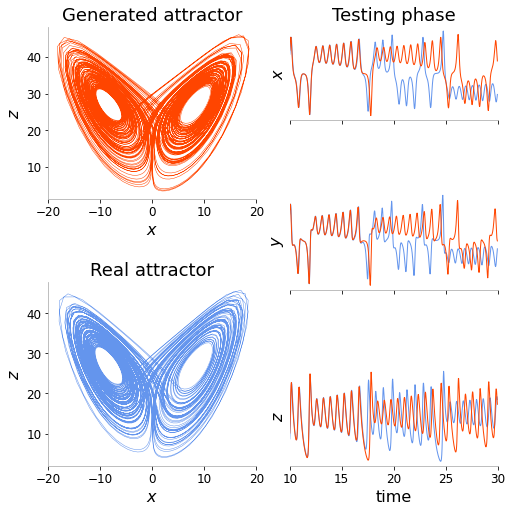

In [10]:
N = round(20 / dt)
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(7, 7), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=6)


ax0 = fig.add_subplot(spec[:3, 0])

ax1 = fig.add_subplot(spec[3:, 0])

ax2 = fig.add_subplot(spec[:2, 1])

ax3 = fig.add_subplot(spec[2:4, 1])

ax4 = fig.add_subplot(spec[4:, 1])

ax0.set_title("Generated attractor")
ax0.set_xlabel("$x$")
ax0.set_ylabel("$z$")
ax0.set_xlim(-20, 20)
ax0.grid(False)
ax0.plot(res[:, 0], res[:, 2], lw=0.5, color="orangered")
ax0.spines["top"].set_color(None)
ax0.spines["right"].set_color(None)

ax1.set_title("Real attractor")
ax1.set_xlim(-20, 20)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$z$")
ax1.grid(False)
ax1.plot(Y[:, 0], Y[:, 2], lw=0.5, color="cornflowerblue")
ax1.spines["top"].set_color(None)
ax1.spines["right"].set_color(None)

ticks = [0, 200, 400, 600, 800]
ticks_values = (np.array(ticks) * 0.025 + train_time).astype(int)

ax2.plot(Y[:N, 0], lw=1, color="cornflowerblue")
ax2.plot(res[:N, 0], lw=1, color="orangered")
ax2.set_title("Testing phase")
ax2.set_ylabel("$x$")
ax2.set_yticks([])
ax2.set_xticks(ticks)
ax2.set_xticklabels([])
ax2.spines["top"].set_color(None)
ax2.spines["left"].set_color(None)
ax2.spines["right"].set_color(None)

ax3.plot(Y[:N, 1], lw=1, color="cornflowerblue")
ax3.plot(res[:N, 1], lw=1, color="orangered")
ax3.set_ylabel("$y$")
ax3.set_yticks([])
ax3.set_xticks(ticks)
ax3.set_xticklabels([])
ax3.spines["top"].set_color(None)
ax3.spines["left"].set_color(None)
ax3.spines["right"].set_color(None)

ax4.plot(Y[:N, 2], lw=1, color="cornflowerblue")
ax4.plot(res[:N, 2], lw=1, color="orangered")
ax4.set_ylabel("$z$")
ax4.set_xlabel("time")
ax4.set_yticks([])
ax4.set_xticks(ticks)
ax4.set_xticklabels(ticks_values)
ax4.spines["top"].set_color(None)
ax4.spines["left"].set_color(None)
ax4.spines["right"].set_color(None)

fig.savefig("../results/fig2.pdf")
plt.show()

## 2. NVAR for double scroll strange attractor forecasting

Same exercise as above, but this time using the double scroll attractor defined by:

$$
\begin{split}
\frac{dx}{dt} &= a(y - x) \\
\frac{dy}{dt} &= (c - a)x - xz + cy \\
\frac{dz}{dt} &= xy - bz
\end{split}
$$

In [11]:
dt = 0.25
train_time  = 100.
test_time   = 800.
warm_time   = 1.
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [12]:
x0 = [0.37926545, 0.058339, -0.08167691]
n_timesteps = train_steps + test_steps + warm_steps

X = doublescroll(n_timesteps, x0=x0, h=dt, method="RK23")

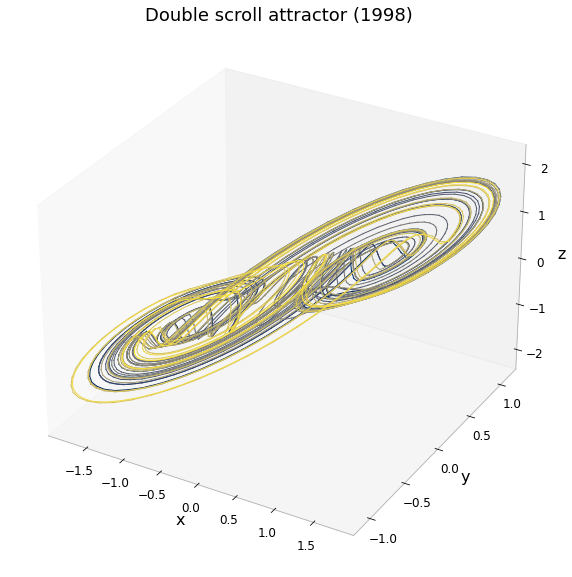

In [13]:
N = train_steps + warm_steps + test_steps

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor (1998)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(N-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//N), lw=1.0)

plt.show()

In [14]:
nvar = NVAR(delay=2, order=3, strides=1)
# The attractor is centered around (0, 0, 0), no bias is required
readout = Ridge(3, ridge=2.5e-6, input_bias=False)
model = nvar >> readout

In [15]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

model = model.fit(Xi, dXi, warmup=warm_steps)

In [16]:
nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

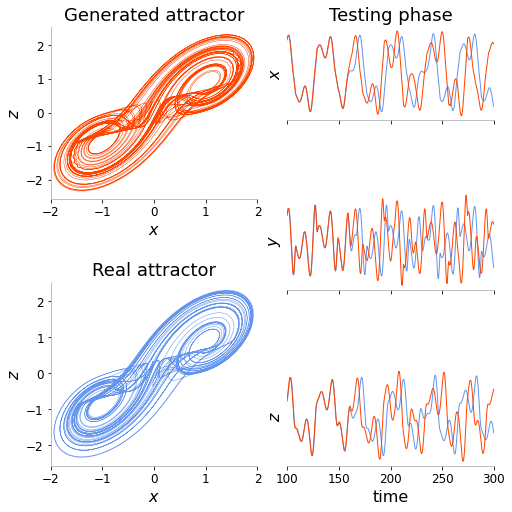

In [17]:
N = round(200 / dt)
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(7, 7), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=6)


ax0 = fig.add_subplot(spec[:3, 0])

ax1 = fig.add_subplot(spec[3:, 0])

ax2 = fig.add_subplot(spec[:2, 1])

ax3 = fig.add_subplot(spec[2:4, 1])

ax4 = fig.add_subplot(spec[4:, 1])

ax0.set_title("Generated attractor")
ax0.set_xlabel("$x$")
ax0.set_ylabel("$z$")
ax0.set_xlim(-2, 2)
ax0.grid(False)
ax0.plot(res[:, 0], res[:, 2], lw=0.5, color="orangered")
ax0.spines["top"].set_color(None)
ax0.spines["right"].set_color(None)

ax1.set_title("Real attractor")
ax1.set_xlim(-2, 2)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$z$")
ax1.grid(False)
ax1.plot(Y[:, 0], Y[:, 2], lw=0.5, color="cornflowerblue")
ax1.spines["top"].set_color(None)
ax1.spines["right"].set_color(None)

ticks = np.linspace(0, N, 5)
ticks_values = (np.array(ticks) * dt + train_time).astype(int)

ax2.plot(Y[:N, 0], lw=1, color="cornflowerblue")
ax2.plot(res[:N, 0], lw=1, color="orangered")
ax2.set_title("Testing phase")
ax2.set_ylabel("$x$")
ax2.set_yticks([])
ax2.set_xticks(ticks)
ax2.set_xticklabels([])
ax2.spines["top"].set_color(None)
ax2.spines["left"].set_color(None)
ax2.spines["right"].set_color(None)

ax3.plot(Y[:N, 1], lw=1, color="cornflowerblue")
ax3.plot(res[:N, 1], lw=1, color="orangered")
ax3.set_ylabel("$y$")
ax3.set_yticks([])
ax3.set_xticks(ticks)
ax3.set_xticklabels([])
ax3.spines["top"].set_color(None)
ax3.spines["left"].set_color(None)
ax3.spines["right"].set_color(None)

ax4.plot(Y[:N, 2], lw=1, color="cornflowerblue")
ax4.plot(res[:N, 2], lw=1, color="orangered")
ax4.set_ylabel("$z$")
ax4.set_xlabel("time")
ax4.set_yticks([])
ax4.set_xticks(ticks)
ax4.set_xticklabels(ticks_values)
ax4.spines["top"].set_color(None)
ax4.spines["left"].set_color(None)
ax4.spines["right"].set_color(None)

fig.savefig("../results/fig3.pdf")
plt.show()

## 3. Reconstruction of $z$ coordinate of Lorenz system from $(x, y)$

We now want to predict coordinate $z[t]$ at time $t$ of a point in the Lorenz attractor given the two other coordinates $(x[t-1], y[t-1])$ at time $t -1$.

In [18]:
# time step duration (in time unit)
dt = 0.05
# training time (in time unit)
train_time  = 20.
# testing time (idem)
test_time   = 45.
# warmup time (idem): should always be > k * s
warm_time   = 5.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [19]:
x0 = [17.67715816276679, 12.931379185960404, 43.91404334248268]
n_timesteps = train_steps + test_steps + warm_steps

X = lorenz(n_timesteps, x0=x0, h=dt, method="RK23")

In [20]:
nvar = NVAR(delay=4, order=2, strides=5)
readout = Ridge(1, ridge=0.05)

model = nvar >> readout

In [21]:
xy  = X[:train_steps+warm_steps-1, :2]
z   = X[1:train_steps+warm_steps, 2][:, np.newaxis]

model = model.fit(xy, z, warmup=warm_steps)

In [22]:
_ = nvar.run(X[train_steps:warm_steps+train_steps, :2])

xy_test = X[warm_steps+train_steps:-1, :2]
res = model.run(xy_test)

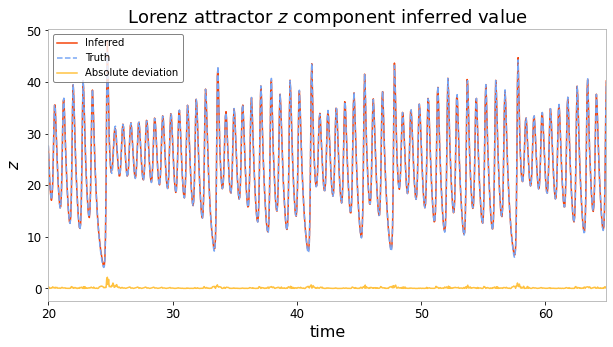

In [23]:
N = round(40 / dt)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(res, label="Inferred")
ax.plot(X[warm_steps+train_steps+1:, 2], label="Truth", linestyle="--")
ax.plot(abs(res[:, 0] - X[warm_steps+train_steps+1:, 2]), label="Absolute deviation")
ax.set_ylabel("$z$")
ax.set_xlabel("time")
ax.set_title("Lorenz attractor $z$ component inferred value")
ax.set_xticks(np.linspace(0, N, 5))
ax.set_xticklabels((np.linspace(0, N, 5) * dt + train_time).astype(int))
plt.legend()

fig.savefig("../results/fig4.pdf")

plt.show()